In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/bangkit-2020-dps04-us-test001/aksara-jawa-v5.zip \
    -O /tmp/aksara-jawa-v5.zip

--2020-06-05 10:55:09--  https://storage.googleapis.com/bangkit-2020-dps04-us-test001/aksara-jawa-v5.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194968769 (186M) [application/zip]
Saving to: ‘/tmp/aksara-jawa-v5.zip’

/tmp/aksara-jawa-v5 100%[===================>] 185.94M  74.8MB/s    in 2.5s    

2020-06-05 10:55:12 (74.8 MB/s) - ‘/tmp/aksara-jawa-v5.zip’ saved [194968769/194968769]



In [0]:
#Unzip files dataset
import os
import zipfile

local_zip = '/tmp/aksara-jawa-v5.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/aksara-jawa/')
zip_ref.close()

In [0]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import time

### Setup dataset Generator

In [4]:
TRAINING_DIR = "/tmp/aksara-jawa/newdatasetaug/newtraining/"
training_datagen = ImageDataGenerator(
    validation_split=.2,
    rescale = 1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

TEST_DIR = "/tmp/aksara-jawa/newdatasetaug/newtesting/"
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='training',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=8
)

validation_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='validation',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=8
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=8
)

Found 1161 images belonging to 20 classes.
Found 280 images belonging to 20 classes.
Found 839 images belonging to 20 classes.


### Create Model

In [5]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(20, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

In [7]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

time_start = time.time()#measure training time
history = model.fit(train_generator, epochs=30, validation_data = validation_generator, verbose = 1, callbacks=[checkpointer])
time_end = time.time()

Epoch 1/30
146/146 [==============================] - ETA: 0s - loss: 3.4133 - accuracy: 0.0767
Epoch 00001: val_loss improved from inf to 2.97770, saving model to weights.best.from_scratch.hdf5
146/146 [==============================] - 41s 278ms/step - loss: 3.4133 - accuracy: 0.0767 - val_loss: 2.9777 - val_accuracy: 0.0857
Epoch 2/30
146/146 [==============================] - ETA: 0s - loss: 2.9330 - accuracy: 0.1180
Epoch 00002: val_loss improved from 2.97770 to 2.77921, saving model to weights.best.from_scratch.hdf5
146/146 [==============================] - 40s 277ms/step - loss: 2.9330 - accuracy: 0.1180 - val_loss: 2.7792 - val_accuracy: 0.1464
Epoch 3/30
146/146 [==============================] - ETA: 0s - loss: 2.7057 - accuracy: 0.1680
Epoch 00003: val_loss improved from 2.77921 to 2.69759, saving model to weights.best.from_scratch.hdf5
146/146 [==============================] - 40s 276ms/step - loss: 2.7057 - accuracy: 0.1680 - val_loss: 2.6976 - val_accuracy: 0.1857
Epoch

In [8]:
elapsed_time = time_end - time_start
print("Elapsed time (s): % 5.2f" %(elapsed_time)) 

Elapsed time (s):  1214.38


In [9]:
model.load_weights('weights.best.from_scratch.hdf5') #load weight terbaik

model.save("aksara.h5")

# Melakukan test
model.evaluate(test_generator)

105/105 [==============================] - 14s 131ms/step - loss: 0.2126 - accuracy: 0.9237


[0.21256934106349945, 0.9237186908721924]

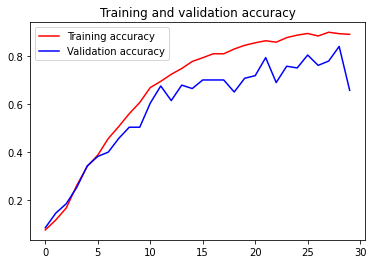

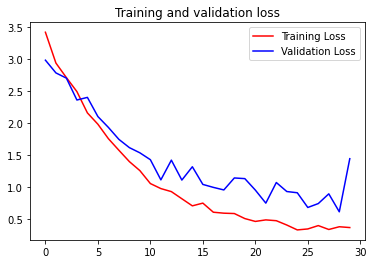

In [10]:
# Plot kurva akurasi
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [13]:
#lakukan test dengan gambar baru
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
    # predicting images
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(fn)
    print(classes)
    
    predicted_class_indices=np.argmax(classes,axis=1)
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print(predictions)



Saving nga220.pred.png to nga220.pred.png
Saving ra164.pred.png to ra164.pred.png
nga220.pred.png
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['ba']
ra164.pred.png
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['ga']


In [0]:
import os
train_ba_dir = os.path.join(TRAINING_DIR, 'ba')
train_ca_dir = os.path.join(TRAINING_DIR, 'ca')

train_ba_fnames = os.listdir( train_ba_dir )
train_ca_fnames = os.listdir( train_ca_dir )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


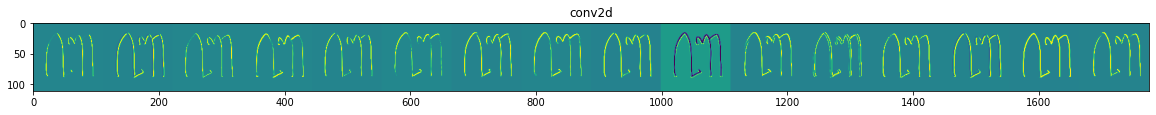

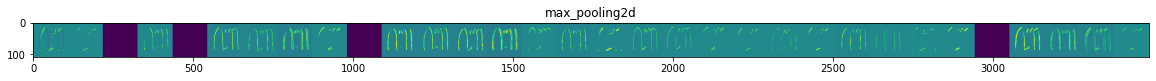

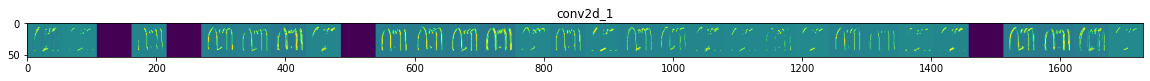

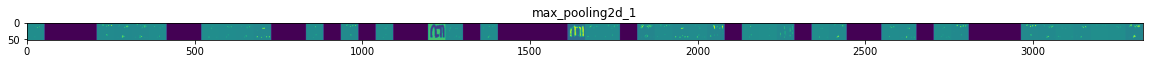

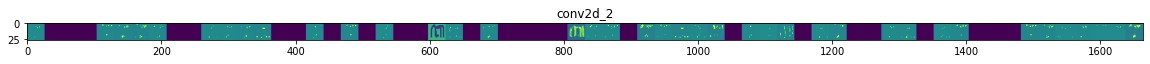

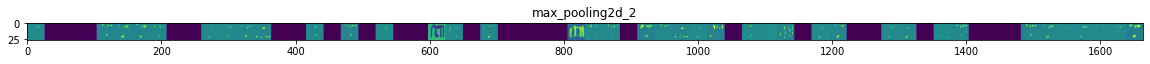

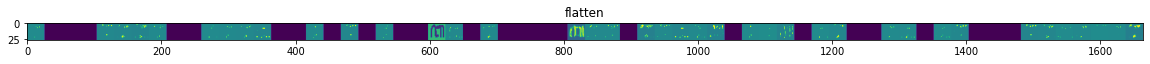

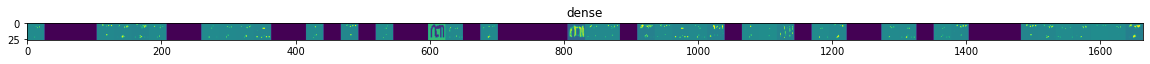

In [15]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image from the training set.
ba_img_files = [os.path.join(train_ba_dir, f) for f in train_ba_fnames]
ca_img_files = [os.path.join(train_ca_dir, f) for f in train_ca_fnames]

img_path = random.choice(ba_img_files + ca_img_files)
img = load_img(img_path, target_size=(224, 224))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]


# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
    if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 